In [1]:
import numpy as np
import os
import re
import plotly.io as pio
import pandas as pd
import random
import matplotlib.pyplot as plt

In [20]:
def get_eval_metric(mtcs, file): # 文件中共有多少次eval，以及最后一次eval的metric值
    i = 0
    metric = '\'f1_score\': '
    target_str = metric + '\d+.?\d+'
    number_str = '\d+.?\d+'
    for line in open(file,"r"):
        if metric in line:
            word = re.findall(target_str, line)[0]
            mtc = re.findall(number_str, word)[0]
            
            mtcs.append(mtc)
            i = i + 1
    return i, mtcs 

def insert_10(left, right):
    l = [left + 1]
    for i in range(left, right):
        if (i - left -1) % 10 == 0 and i != left + 1:
            l.append(i)
    l.append(right)
    return l

def merge_stack(lists):
    for i in range(len(lists)):
        merged_l = []
        l = lists[i]
        for a in l:
            for b in a:
                merged_l.append(b)
        lists[i] = merged_l
    return lists

def cut(x,y,upper_bound_acc):
    threshold = 0
    delete_y = [t for t in y if t > upper_bound_acc]
    if len(delete_y) > 0:
        if isinstance(y, list):
            threshold = y.index(delete_y[0])
        else:
            threshold = y.tolist().index(delete_y[0])
    else:
        threshold = len(y)
    y = y[:threshold]
    x = x[:threshold]
    return x,y
            
def sum_duration(depth, width, idx, tmp, time, type = "Dyna-A-Freeze"):
    batch_num = 20
    latency_tx2_baseline = np.array([0.5325, 0.612, 0.696, 0.791, 0.883, 0.9713, 1.064, 1.156, 1.2465, 1.33, 1.419, 1.51, 1.7])
    latency_tx2_cached = np.array([0.02, 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.90, 0.99, 1.08])
    comm_bert = np.array([0.6, 7.7, 14.8, 21.9, 29.0, 36.0, 43.1, 50.2, 57.3, 64.4, 71.5, 78.6, 109.5]) * 32 / 8 # 这里面没有仅仅freeze embedding的数据
    adapter_para = 0.0125 * width / 8
    comm_adapter =np.array([0.02 + i * adapter_para for i in range(0,13)]) * 4
    
    if type == "BERT" or type == "Freeze":
        latency = latency_tx2_baseline
        comm = comm_bert * 2
    if type == "Q-8":
        latency = latency_tx2_baseline
        comm = comm_bert * 2 / 4  # INT8 量化
    if type == "Quantize" or type == "Q-Freeze": # 使用误差补偿的方法; Quantize Freeze; TODO:混合精度量化
        latency = latency_tx2_baseline
        comm = comm_bert * 2 / 8  # INT4 量化
    if type == "A-Freeze" or type == "Dyna-A-Freeze":
        latency = latency_tx2_cached 
        comm = comm_adapter * 2

    comm_tmp = comm[depth]
    duration = 0
    for i in range(0, idx - tmp):
        comp_tmp = latency[depth] * batch_num
        duration = duration + comp_tmp + comm_tmp
    if len(time) > 0:
        time.append(duration + time[-1])
    else:
        time.append(duration)
    return time


In [6]:
root_path = "/home/cdq/FedNLP"
log_root_path = "experiments/distributed/transformer_exps/run_st_exps/results/BERT/onto-Trail-0-60"
log_file_name = "fednlp_tc_deep_0.log"
file = os.path.join(root_path, log_root_path, log_file_name)

In [7]:
# depth, width, round, metric
dwrm = [[0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3], [8, 8, 8, 16, 16, 16, 24, 32, 32, 32, 40, 48, 48, 48, 56, 64, 64, 64, 64, 64], [-1, 79, 88, 180, 272, 364, 453, 539, 625, 711, 794, 875, 956, 1037, 1115, 1191, 1267, 1343, 1393, 1467], [0, '0.4681359532660648', '0.602761550716941', '0.7422995220392989', '0.7559745087626129', '0.7636749867233139', '0.7684545937334042', '0.7729686670207117', '0.7804036112586299', '0.7838555496548062', '0.7892989909718534', '0.7934147636749868', '0.7954062665958577', '0.7966011683483802', '0.7980616038236856', '0.8005841741901222', '0.8029739776951673', '0.8016463090812533', '0.8020446096654275', '0.8031067445565587']]


flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)
print(merged_new_dwrm)
# for depth in dwrm:

[[[0, 0], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 3]], [[8, 8], [8, 8], [16, 16], [16, 16], [16, 16], [24, 24], [32, 32], [32, 32], [32, 32], [40, 40], [48, 48], [48, 48], [48, 48], [56, 56], [64, 64], [64, 64], [64, 64], [64, 64], [64, 64]], [[0, 10, 20, 30, 40, 50, 60, 70, 79], [80, 88], [89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 180], [181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 272], [273, 283, 293, 303, 313, 323, 333, 343, 353, 363, 364], [365, 375, 385, 395, 405, 415, 425, 435, 445, 453], [454, 464, 474, 484, 494, 504, 514, 524, 534, 539], [540, 550, 560, 570, 580, 590, 600, 610, 620, 625], [626, 636, 646, 656, 666, 676, 686, 696, 706, 711], [712, 722, 732, 742, 752, 762, 772, 782, 792, 794], [795, 805, 815, 825, 835, 845, 855, 865, 875], [876, 886, 896, 906, 916, 926, 936, 946, 956], [957, 967, 977, 987, 997, 1007, 1017, 1027, 1037], [1038, 1048, 1058, 1068, 1078, 1088

In [15]:
Origin = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_st_exps/results/Baseline/onto_niid_label_clients=600_alpha=1_lr=0.1_freeze=_quantize=False_adapter=False.txt"
Distil = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/results/Baseline/20news_uniform_lr=0.1_freeze=_quantize=True_adapter=False_works=5.txt"
Q_Freeze_d_2 = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_st_exps/results/Baseline/onto_niid_label_clients=600_alpha=1_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=True_adapter=False.txt"
Freeze_d_2 = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_st_exps/results/Baseline/onto_niid_label_clients=600_alpha=1_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=False_adapter=False.txt"
Q_Freeze_d_4 = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_st_exps/results/Baseline/onto_niid_label_clients=600_alpha=1_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=True_adapter=False.txt"
Freeze_d_4 = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_st_exps/results/Baseline/onto_niid_label_clients=600_alpha=1_lr=0.1_freeze=e,0,1,2,3,4,5,6,7_quantize=False_adapter=False.txt"
Q_Freeze_d_6 = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_st_exps/results/Baseline/onto_niid_label_clients=600_alpha=1_lr=0.1_freeze=e,0,1,2,3,4,5_quantize=True_adapter=False.txt"
Freeze_d_6 = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_st_exps/results/Baseline/onto_niid_label_clients=600_alpha=1_lr=0.1_freeze=e,0,1,2,3,4,5_quantize=False_adapter=False.txt"
def load_baseline(depth, file):
    baseline = []
    for line in open(file,"r"):
        baseline.append(float(line))
    baseline_len = len(baseline)
    baseline_drm = [[depth]*baseline_len, (np.array(range(0, baseline_len))*5).tolist(), baseline]
    return baseline_drm
baseline_origin_drm = load_baseline(12, Origin)
baseline_distil = load_baseline(12, Distil)
baseline_q_freeze_drm_d_2 = load_baseline(2, Q_Freeze_d_2)
baseline_freeze_drm_d_2 = load_baseline(2, Freeze_d_2)
baseline_q_freeze_drm_d_4 = load_baseline(4, Q_Freeze_d_4)
baseline_freeze_drm_d_4 = load_baseline(4, Freeze_d_4)
baseline_q_freeze_drm_d_6 = load_baseline(6, Q_Freeze_d_4)
baseline_freeze_drm_d_6 = load_baseline(6, Freeze_d_4)

A-Freeze4 9.062044444444384
A-Freeze3 6.836988888888857
A-Freeze2 4.611933333333357
A-Freeze1 2.386877777777794
A-Freeze0 0.566377777777774
A-Freeze6 13.512155555555466
A-Freeze12 26.862488888889008


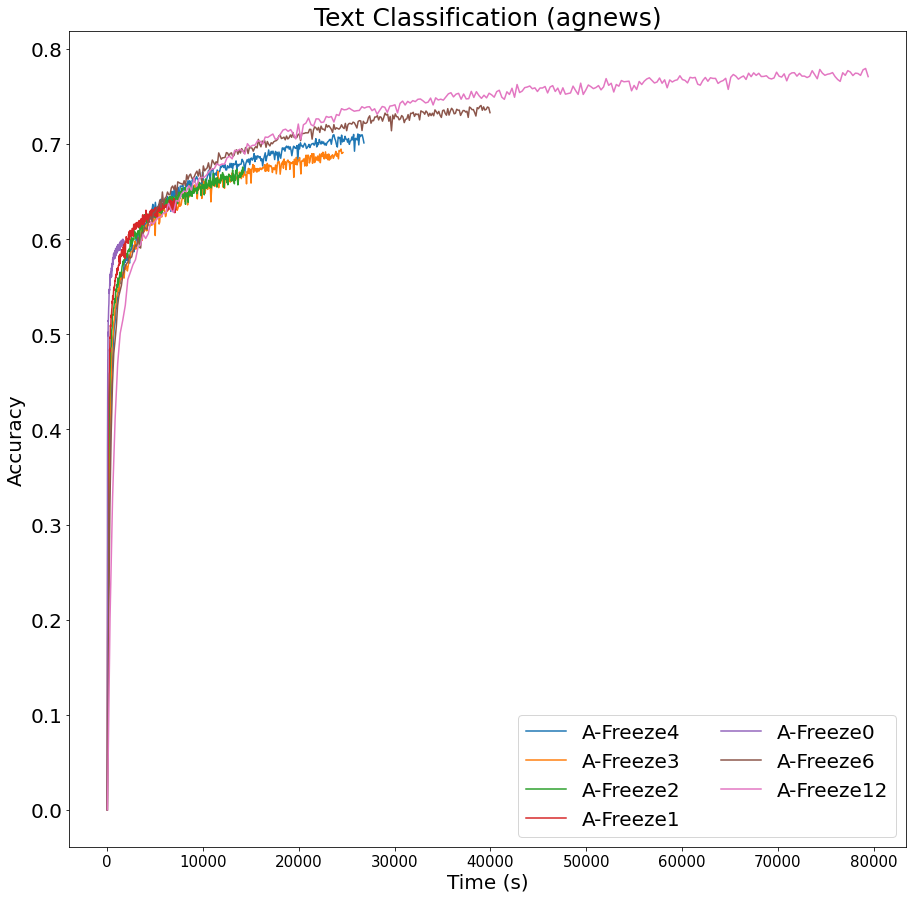

In [24]:
plt.figure(figsize=(15,15))
plt.title("Text Classification (agnews)",fontsize=25)
# 设置刻度字体大小
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
max_acc = 0.8
target_acc = 1
max_acc = max_acc * target_acc

# vanillar adapter
data_path = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_st_exps/results/Baseline/onto-adapter.csv" # Adapter

raw_data = pd.read_csv(data_path,index_col=0)
column_name = raw_data.columns.values
for col in column_name:
    y = raw_data[col]
    x = (np.array(range(0, len(y)))*10).tolist()

    d = int(col.split("-")[1])
    w = 32
    
    time = []
    tmp = -1 # 记录最后一个访问的idx
    
    for idx in x:
        time = sum_duration(d, w, idx, tmp, time, "A-Freeze")
        tmp = idx 
    
    time, y = cut(time, y, max_acc)
    plt.plot(np.array(time), y, label = "A-Freeze" + str(d))
    print("A-Freeze" + str(d),time[-1]/3600)

plt.legend(fontsize=20,ncol = 2)
plt.savefig('./pic/onto-A-Freeze.png', bbox_inches="tight")


BERT 38.169444444444444
Q-Freeze-d-2 6.62953333333332
Freeze-d-2 29.07364444444451
Q-Freeze-d-4 10.770683333333332
Freeze-d-4 21.56785000000002
Q-Freeze-d-6 14.861050000000041
Freeze-d-6 31.625244444444412


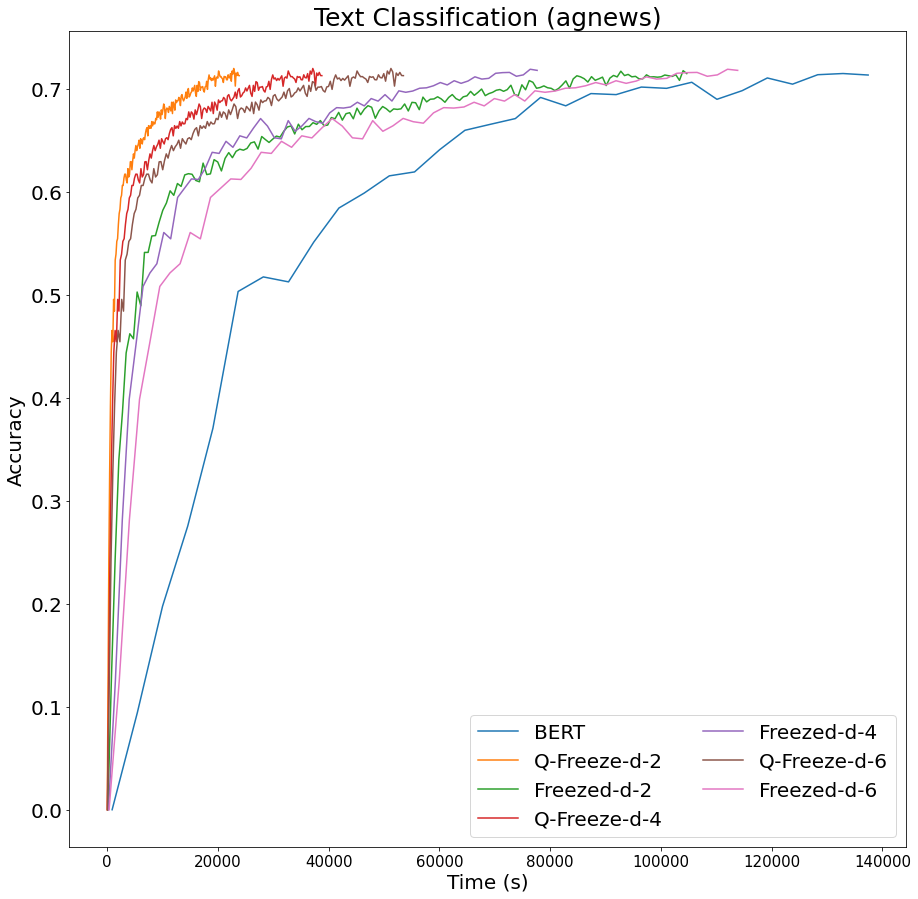

In [23]:
plt.figure(figsize=(15,15))
plt.title("Text Classification (agnews)",fontsize=25)
# 设置刻度字体大小
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
max_acc = 0.8
target_acc = 0.90
max_acc = max_acc * target_acc

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_origin_drm
y = [float(i) for i in baseline_origin_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "BERT")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "BERT")
print("BERT",time[-1]/3600)

# time = []
# tmp = -1 # 记录最后一个访问的idx
# data = baseline_distil
# y = [float(i) for i in baseline_origin_drm[2]]
# for idx in data[1]:
#     id = data[1].index(idx)
#     d = data[0][id]
#     w = 0
#     time = sum_duration(d, w, idx, tmp, time, "Q-8")
#     tmp = idx

# time, y = cut(time, y, max_acc)
# plt.plot(np.array(time), y, label = "Quantize-8")
# print("Quantize-8",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_q_freeze_drm_d_2
y = [float(i) for i in baseline_q_freeze_drm_d_2[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Q-Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Q-Freeze-d-2")
print("Q-Freeze-d-2",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_freeze_drm_d_2
y = [float(i) for i in baseline_freeze_drm_d_2[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Freezed-d-2")
print("Freeze-d-2",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_q_freeze_drm_d_4
y = [float(i) for i in baseline_q_freeze_drm_d_4[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Q-Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Q-Freeze-d-4")
print("Q-Freeze-d-4",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_freeze_drm_d_4
y = [float(i) for i in baseline_freeze_drm_d_4[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Freezed-d-4")
print("Freeze-d-4",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_q_freeze_drm_d_6
y = [float(i) for i in baseline_q_freeze_drm_d_6[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Q-Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Q-Freeze-d-6")
print("Q-Freeze-d-6",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_freeze_drm_d_6
y = [float(i) for i in baseline_freeze_drm_d_6[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Freezed-d-6")
print("Freeze-d-6",time[-1]/3600)

plt.legend(fontsize=20,ncol = 2)
plt.savefig('./pic/onto-baseline.png', bbox_inches="tight")

A-Freeze4 9.062044444444384
A-Freeze3 6.836988888888857
A-Freeze2 4.611933333333357
A-Freeze1 2.386877777777794
A-Freeze0 0.566377777777774
A-Freeze6 6.312599999999989
A-Freeze12 5.466933333333332
BERT 38.169444444444444
Quantize-8 10.611944444444445
Q-Freeze-d-2 6.62953333333332
Freeze-d-2 29.07364444444451
Q-Freeze-d-4 10.770683333333332
Freeze-d-4 54.85584999999988


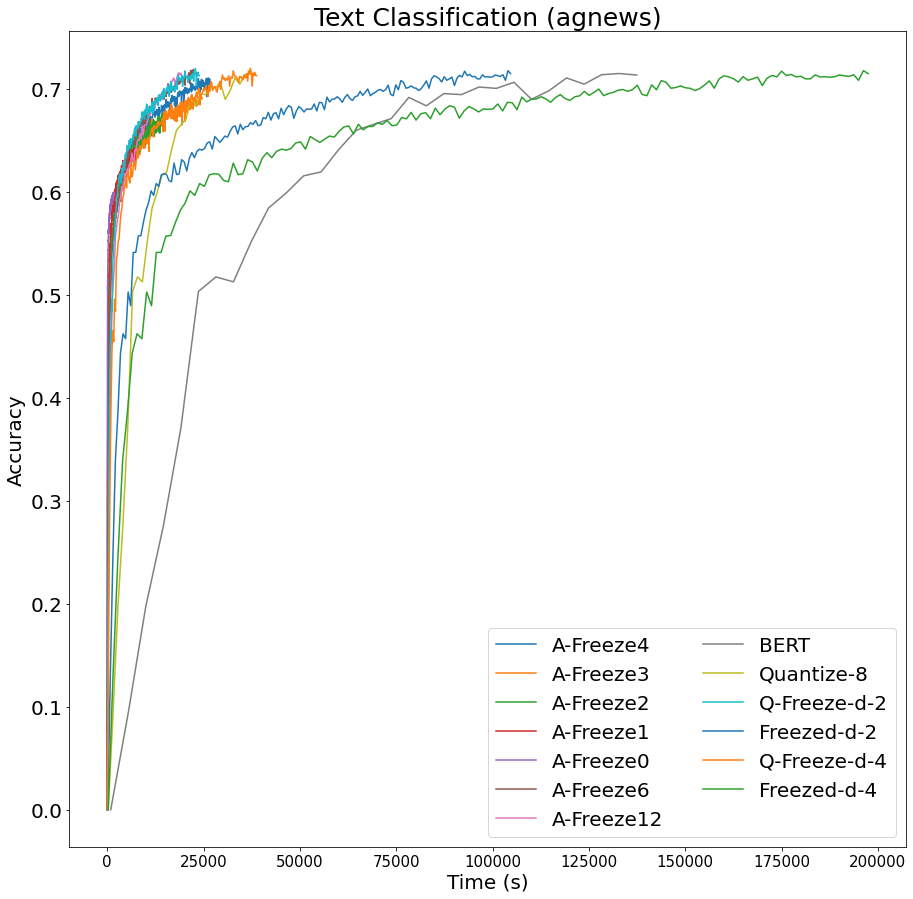

In [19]:
plt.figure(figsize=(15,15))
plt.title("Text Classification (agnews)",fontsize=25)
# 设置刻度字体大小
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
max_acc = 0.8
target_acc = 0.90
max_acc = max_acc * target_acc

# vanillar adapter
data_path = "/home/cdq/FedNLP/experiments/distributed/transformer_exps/run_st_exps/results/Baseline/onto-adapter.csv" # Adapter

raw_data = pd.read_csv(data_path,index_col=0)
column_name = raw_data.columns.values
for col in column_name:
    y = raw_data[col]
    x = (np.array(range(0, len(y)))*10).tolist()

    d = int(col.split("-")[1])
    w = 32
    
    time = []
    tmp = -1 # 记录最后一个访问的idx
    
    for idx in x:
        time = sum_duration(d, w, idx, tmp, time, "A-Freeze")
        tmp = idx 
    
    time, y = cut(time, y, max_acc)
    plt.plot(np.array(time), y, label = "A-Freeze" + str(d))
    print("A-Freeze" + str(d),time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_origin_drm
y = [float(i) for i in baseline_origin_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "BERT")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "BERT")
print("BERT",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_distil
y = [float(i) for i in baseline_origin_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Q-8")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Quantize-8")
print("Quantize-8",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_q_freeze_drm_d_2
y = [float(i) for i in baseline_q_freeze_drm_d_2[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Q-Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Q-Freeze-d-2")
print("Q-Freeze-d-2",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_freeze_drm_d_2
y = [float(i) for i in baseline_freeze_drm_d_2[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Freezed-d-2")
print("Freeze-d-2",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_q_freeze_drm_d_4
y = [float(i) for i in baseline_q_freeze_drm_d_4[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Q-Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Q-Freeze-d-4")
print("Q-Freeze-d-4",time[-1]/3600)

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_freeze_drm_d_4
y = [float(i) for i in baseline_freeze_drm_d_4[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), y, label = "Freezed-d-4")
print("Freeze-d-4",time[-1]/3600)

plt.legend(fontsize=20,ncol = 2)
plt.savefig('./pic/onto-all.png', bbox_inches="tight")
